<a href="https://colab.research.google.com/github/rontalapoojareddy/DeepLearning1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 2503B05130
# Rontala Pooja Reddy
# M.Tech (CSE)

**Import Libraries (Colab)**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


**Device Setup**

In [5]:
T = 50
beta = torch.linspace(1e-4, 0.02, T).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_sample(x0, t, noise):
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_1_ab = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_ab * x0 + sqrt_1_ab * noise


**Load MNIST Dataset**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # [-1,1]
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 24.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 606kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.73MB/s]


**Diffusion Noise Scheduler**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# ===== DIFFUSION PROCESS =====

T = 50  # reduced for speed

beta = torch.linspace(1e-4, 0.02, T, device=device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise


Using device: cpu


**U-Net Model (Reverse Process)**

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(1, 32)
        self.down2 = DoubleConv(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.up = DoubleConv(64 + 32, 32)
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool(x1))
        x = F.interpolate(x2, scale_factor=2)
        x = self.up(torch.cat([x, x1], dim=1))
        return self.out(x)

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


**Initialize Model & Optimizer**

In [7]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


**Training Loop**

In [7]:
epochs = 2

for epoch in range(epochs):
    model.train()
    for images, _ in dataloader:
        images = images.to(device)

        t = torch.randint(0, T, (images.size(0),), device=device)
        noise = torch.randn_like(images)

        x_t = q_sample(images, t, noise)
        noise_pred = model(x_t)

        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss {loss.item():.4f}")


Epoch 1 Loss 0.2089
Epoch 2 Loss 0.1729


**Sampling (Image Generation)**

In [8]:
@torch.no_grad()
def sample(model, n=25):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)

    for t in reversed(range(T)):
        noise_pred = model(x)
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = beta[t]

        mean = (1 / torch.sqrt(alpha_t)) * (
            x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred
        )

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = mean + torch.sqrt(beta_t) * noise

    return (x + 1) / 2


**Generate & Display Images**

(np.float64(-0.5), np.float64(151.5), np.float64(151.5), np.float64(-0.5))

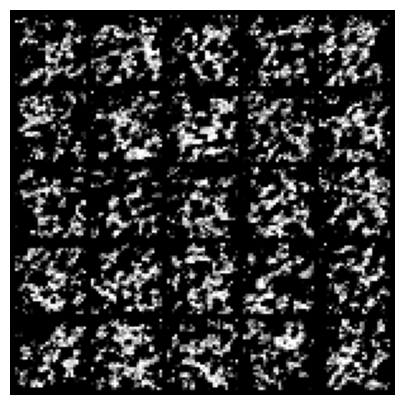

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

@torch.no_grad()
def sample(model, n_samples=25):
    model.eval()

    x = torch.randn(n_samples, 1, 28, 28).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(x)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha[t])) * (
            x - ((1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t])) * noise_pred
        ) + torch.sqrt(beta[t]) * noise

    return x

samples = sample(model)

save_image(samples, "ddpm_mnist.png", nrow=5)

plt.figure(figsize=(5,5))
plt.imshow(plt.imread("ddpm_mnist.png"))
plt.axis("off")



**Classifier Model**

In [12]:
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)

clf_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


**Train Classifier on MNIST**

In [13]:
for epoch in range(5):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        preds = classifier(images)
        loss = criterion(preds, labels)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

    print(f"Classifier Epoch {epoch+1} Loss {loss.item():.4f}")


Classifier Epoch 1 Loss 0.4862
Classifier Epoch 2 Loss 0.1361
Classifier Epoch 3 Loss 0.1704
Classifier Epoch 4 Loss 0.0429
Classifier Epoch 5 Loss 0.5599


**Evaluation Metrics**

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

classifier.eval()
true, pred = [], []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        outputs = classifier(images)
        predictions = outputs.argmax(1)

        true.extend(labels.numpy())
        pred.extend(predictions.cpu().numpy())

acc = accuracy_score(true, pred)
prec, rec, f1, _ = precision_recall_fscore_support(true, pred, average="macro")
cm = confusion_matrix(true, pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)


Accuracy: 0.9388
Precision: 0.9401327786523874
Recall: 0.9374145307993478
F1-score: 0.9374642498886837
Confusion Matrix:
 [[472   0   0   1   0   0   2   3   1   0]
 [  0 549   2   0   0   1   0   2   8   1]
 [  5   7 418   6   8   3   7  11  22   1]
 [  2   5   3 430   1  19   2  11  16   4]
 [  1   2   0   0 515   0   5   1   4   7]
 [  3   2   2   8   2 388   8   1  18   2]
 [  2   2   0   0   0   3 490   0   4   0]
 [  2   1   1   0   4   0   0 533   4   5]
 [  0   2   0   2   3   2   2   0 450   1]
 [  5   1   0   3   6   2   1  21   7 449]]
